#### Import packages

Download the python chess package

In [2]:
pip install chess

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages to us
import os
import chess
import chess.engine
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import numpy as np
import asyncio
from collections import defaultdict

#### Set up folders to stockfish (chess engine) and data csv file

Download stockfish from: https://stockfishchess.org/download/

I'm using version 15 here. Frustratingly, what version you use seems to matter for some things, but probably just using the most recent is a way to go.

Download data from: http://csslab.cs.toronto.edu/datasets/#maia_kdd

I'm using the january CSV here

In [4]:
stockfish_path = "/home/allenwu/Senior Thesis/stockfish_14.1_linux_x64_avx2/stockfish_14.1_linux_x64_avx2"
# stockfish_path = "/home/allenwu/Senior Thesis/stockfish_15_linux_x64_avx2/stockfish_15_x64_avx2"
chess_csv_file = '/scratch/gpfs/allenwu/lichess_db_standard_rated_2019-01.csv'
# chess_csv_file = "/home/allenwu/Senior Thesis/stockfish_14.1_linux_x64_avx2/stockfish_14.1_linux_x64_avx2"

In [4]:
# Open the CSV file in read mode
with open(chess_csv_file, 'r') as file:
    # Use a generator expression to iterate through each line in the file
    # and count the number of lines
    num_rows = sum(1 for line in file)

# Subtract 1 to exclude the header row, if there is one
# Adjust this step based on your specific file structure
num_rows -= 1

print("Number of rows in the CSV file:", num_rows)

Number of rows in the CSV file: 151072060


#### Read in 1000 rows of data

Each row is a move from a game (game_id), made by a player (player_id), we also have elo, white/black, etc.
"board" gives the "fen" - this the location of each piece on the position - prior to the move
"clock" gives the clock time at the end of the turn.
"time_control" specifies what the initial clock setting is for each player (e.g. 600 seconds) and also how much time they get back after each move (this comes after the "+"). "move" specifies what move the player made. "white_active" specifies which player (black or white) made the move

In [8]:
# data_raw = pd.read_csv(chess_data_fullfile, nrows=1000)
data = pd.read_csv(chess_csv_file, nrows=1000000)

filtered_data_elo_novice = data[(data['white_elo'] >= 0) & (data['white_elo'] < 1200) & (data['black_elo'] >= 0) & (data['black_elo'] < 1200)]
filtered_data_elo_amateur = data[(data['white_elo'] >= 1200) & (data['white_elo'] < 1600) & (data['black_elo'] >= 1200) & (data['black_elo'] < 1600)]
filtered_data_elo_advanced = data[(data['white_elo'] >= 1600) & (data['white_elo'] < 2000) & (data['black_elo'] >= 1600) & (data['black_elo'] < 2000)]
filtered_data_elo_master = data[(data['white_elo'] >= 2000) & (data['black_elo'] >= 2000)]


# print(data.iloc[200:225])
# print(len(data))
# print(len(filtered_data_elo_novice))
# print(len(filtered_data_elo_amateur))
# print(len(filtered_data_elo_advanced))
# print(len(filtered_data_elo_master))

# 3 minutes
filtered_data_time_blitz = data[(data['time_control'] == '180+0')]
# 10 minutes
filtered_data_time_rapid = data[data['time_control'] == '600+0']

# 1 minute
filtered_data_time_bullet = data[(data['time_control'] == '60+0')]

# 30 minute
filtered_data_time_standard = data[(data['time_control'] == '1800+0')]
filtered_data_time_standard_2 = data[(data['time_control'] == '2700+0')]

print(len(filtered_data_time_blitz))
print(len(filtered_data_time_rapid))
print(len(filtered_data_time_bullet))
print(len(filtered_data_time_standard))
print(len(filtered_data_time_standard_2))

116477
183154
139489
3093
195


In [30]:
time_control_hm = defaultdict(int)
for i, time_control in enumerate(data['time_control'][:1000000]):
    time_control_hm[time_control] += 1
print(time_control_hm.keys())

dict_keys(['600+0', '300+0', '60+0', '180+2', '180+0', '300+3', '900+15', '15+0', '120+0', '900+0', '600+5', '120+1', '180+1', '360+0', '900+1', '1200+0', '30+0', '60+2', '300+10', '300+2', '480+8', '600+10', '360+6', '1200+20', '1200+5', '0+1', '-', '45+3', '1800+0', '3600+0', '900+10', '540+6', '900+5', '1500+0', '300+5', '1140+9', '1800+30', '420+2', '420+3', '600+15', '600+3', '60+1', '180+12', '60+10', '720+0', '1200+15', '720+4', '60+3', '540+2', '120+3', '1500+20', '540+16', '420+0', '240+4', '900+25', '300+4', '1140+0', '1800+5', '600+4', '480+0', '480+2', '0+2', '15+4', '300+8', '240+0', '480+3', '90+2', '120+10', '180+3', '240+3', '120+4', '2700+0', '600+1', '240+5', '300+20', '300+1', '90+3', '600+2', '660+0', '2400+0', '1200+7', '660+4', '180+6', '900+3', '360+1', '1500+2', '1800+15', '0+4', '120+2', '660+15', '420+5', '900+20', '180+4', '780+5', '180+8', '600+8', '1800+10', '240+2', '540+5', '720+1', '420+8', '420+30', '480+10', '300+6', '1500+10', '540+0', '1500+25', '108

#### For each move in the dataset, call this helper function to return a list of delta(material)'s, returning material changes for a depth of the next 5 moves.

In [6]:
# use this_fen to count pieces of each player (white is uppercase, black is lowercase)
# we want to calculate material_change in depth of 5 in stockfish's line of pv, as opposed to the actual sequence here
# (this is similar to what I do in stockfish but return 5 moves instead of 1 recommended move), then loop through 5 moves and
# calculate material change delta (return both players material changes in a tuple for each index) --> (active, inactive) format
def material(last_board, board, active_player):
    this_fen = board.fen()
    this_white_material, this_black_material = 0, 0
    for i in range(len(this_fen)):
        char = this_fen[i]
        if char == " ":
            break
        elif char == "/" or char.isnumeric() or char == "k" or char == "K":
            continue
        elif char.islower():
            if char == "p":
                this_black_material += 1
            elif char == "r":
                this_black_material += 5
            elif char == "n" or char == "b":
                this_black_material += 3
            else:
                this_black_material += 9
        else:
            if char == "P":
                this_white_material += 1
            elif char == "R":
                this_white_material += 5
            elif char == "N" or char == "B":
                this_white_material += 3
            else:
                this_white_material += 9
#     print(this_fen)
#     print(this_white_material, this_black_material)
        
    last_fen = last_board.fen()
    last_white_material, last_black_material = 0, 0
    for i in range(len(last_fen)):
        char = last_fen[i]
        if char == " ":
            break
        elif char == "/" or char.isnumeric() or char == "k" or char == "K":
            continue
        elif char.islower():
            if char == "p":
                last_black_material += 1
            elif char == "r":
                last_black_material += 5
            elif char == "n" or char == "b":
                last_black_material += 3
            else:
                last_black_material += 9
        else:
            if char == "P":
                last_white_material += 1
            elif char == "R":
                last_white_material += 5
            elif char == "N" or char == "B":
                last_white_material += 3
            else:
                last_white_material += 9
#     print(last_fen)
#     print(last_white_material, last_black_material)
                
    white_change = last_white_material - this_white_material
    black_change = last_black_material - this_black_material
    # if white_move made, only black_material can change and vice versa
    if active_player == "white":
        return black_change
    return white_change

def delta_material(stockfish_moves, current_board, active_player):
    active_delta_material, opponent_delta_material = [], []
    board = current_board.copy()
    
    for i in range(len(stockfish_moves)):
        last_board = board.copy()
        board.push_uci(stockfish_moves[i].uci())
        
        this_active_player = ""
        # all even moves = stockfish-recommended moves for the active_player --> if active player, only opponent player can lose material...
        if i % 2 == 0:
            this_active_player = active_player
            material_change = material(last_board, board, this_active_player)
            opponent_delta_material.append(material_change)
        else:
            if active_player == "white":
                this_active_player = "black"
            else:
                this_active_player = "white"
            
            material_change = material(last_board, board, this_active_player)
            active_delta_material.append(material_change)
            
    return [active_delta_material, opponent_delta_material]

#### Initialize the engine

I've used the python-chess package to communicate with the engine.

https://python-chess.readthedocs.io/en/latest/engine.html

In [7]:
# stockfish 14.1 is the most recent version that works
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

#### Select an example position and display it

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
<class 'str'>


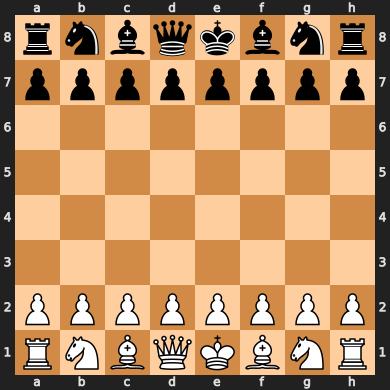

white to move
move selected: e2e4


In [8]:
data_idx = 0
this_row = data.loc[data_idx,:]
this_fen = this_row.board
this_white_active = this_row.white_active
player_to_move = "white" if this_white_active else "black"

current_board = chess.Board(this_fen);
print(current_board)
print(this_fen)
print(type(this_fen))

display(current_board)
print('{} to move'.format(player_to_move))

this_move = this_row.move
print('move selected: {}'.format(this_move))

In [9]:
# modified original approach to only print highest depth return info
# need to generalize this to take in any given current_board
def stockfish(current_board, desired_depth=15, num_moves=6):
    info = engine.analyse(current_board, chess.engine.Limit(depth=desired_depth))
    stockfish_pv = info['pv']
    stockfish_eval_score = info['score'].relative.score()
    return (stockfish_pv[0:num_moves], stockfish_eval_score)
stockfish(current_board)

([Move.from_uci('d2d4'),
  Move.from_uci('g8f6'),
  Move.from_uci('c2c4'),
  Move.from_uci('e7e6'),
  Move.from_uci('g1f3'),
  Move.from_uci('d7d5')],
 42)

In [10]:
stockfish_tuple = stockfish(current_board)
moves, stockfish_eval_score = stockfish_tuple[0], stockfish_tuple[1]
print(moves)
print(moves[1])
print(type(moves[1]))
print(moves[1].uci())
print(type(moves[1].uci()))

[Move.from_uci('e2e4'), Move.from_uci('c7c5'), Move.from_uci('g1f3'), Move.from_uci('d7d6'), Move.from_uci('f1b5'), Move.from_uci('c8d7')]
c7c5
<class 'chess.Move'>
c7c5
<class 'str'>


In [13]:
# QUESTION: why does this return smth different every time?
def collect_data(desired_depth=15, num_moves=6):
    # returns (delta_materials, move_match) --> tuple(2d matrix, 1d vector)
    delta_materials, move_match = [], []
    
    for i, move in enumerate(data['move'][:100]):        
        this_row = data.loc[i,:]
        this_fen, this_white_active = this_row.board, this_row.white_active
        current_board = chess.Board(this_fen)
        active_player = "white" if this_white_active else "black"
        
        # stockfish_tuple = (stockfish_moves, stockfish_score)
        # stockfish_score unused now, but may use later as another heuristic
        stockfish_tuple = stockfish(current_board, desired_depth, num_moves)
        stockfish_moves, stockfish_score = stockfish_tuple[0], stockfish_tuple[1]
        
        # append active_player and opponent_player material losses separately
        delta_material_tuple = delta_material(stockfish_moves, current_board, active_player)
        active_delta_material, opponent_delta_material = delta_material_tuple[0], delta_material_tuple[1]
        
        if len(active_delta_material) == 3 and len(opponent_delta_material) == 3:
            delta_materials.append([active_delta_material, opponent_delta_material])

            # need to append move_match binary of active_player AND opponent move
            stockfish_move = stockfish_moves[0]
            if str(stockfish_move) == str(move):
                move_match.append(1)
            else:
                move_match.append(0)
            
        # check opponent move against first stockfish move too
        # HAVING PROBLEMS WITH THIS: 
#         opponent_move = data['move'][i+1]
#         current_board.push_uci(stockfish_move.uci())
#         stockfish_opponent_move = stockfish(current_board, desired_depth, num_moves)[0][0]
#         if str(stockfish_opponent_move) == str(opponent_move):
#             move_match.append(1)
#         else:
#             move_match.append(0)
            
    print(len(delta_materials), len(move_match))
    return [delta_materials, move_match]
collect_data()

100 100


[[[[0, 0, 0], [0, 0, 0]],
  [[0, 0, 1], [0, 0, 1]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 1, 0], [0, 0, 0]],
  [[3, 0, 0], [1, 3, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[1, 0, 3], [0, 0, 3]],
  [[0, 3, 0], [1, 0, 3]],
  [[1, 0, 3], [0, 1, 3]],
  [[0, 3, 0], [1, 3, 0]],
  [[1, 0, 0], [1, 0, 0]],
  [[1, 0, 1], [0, 0, 3]],
  [[0, 3, 0], [3, 1, 3]],
  [[1, 3, 0], [0, 3, 0]],
  [[3, 0, 0], [1, 3, 0]],
  [[3, 0, 0], [3, 0, 0]],
  [[3, 5, 1], [3, 5, 0]],
  [[5, 0, 3], [3, 5, 1]],
  [[5, 1, 0], [5, 0, 3]],
  [[0, 3, 0], [5, 1, 0]],
  [[1, 0, 0], [0, 3, 0]],
  [[0, 0, 0], [1, 0, 0]],
  [[1, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [1, 0, 0]],
  [[1, 1, 9], [0, 0, 3]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[3, 0, 0], [1, 9, 0]],
  [[3, 0, 0], [0, 0, 0]],
  [[3, 0, 3], [0, 9, 3]],
  [[9, 0, 3], [3, 0, 0]],
  [[1, 0, 0], [3, 9, 0]],
  [[0, 0, 0], [0, 0, 0]],
  [[0, 0, 1], [0, 0, 1]],
  [[0, 0, 0]

In [219]:
# NOTE: old work, will need to update for data ag
# def get_accuracy_maps(desired_depth=15, num_moves=6):
    # {delta_materials : [total_correct, total]} --> returning delta_materials only is most flexible
    # first collect data, then aggregate them into (maps, etc.) later
#     delta_material_to_accuracy = defaultdict(int)
#     stockfish_score_to_accuracy = defaultdict(int)
#     joint_accuracy = defaultdict(int)
#     total, total_correct = 0, 0

#         curr_joint_accuracy = stockfish_score * sum_recent_delta_materials
        
#             total_correct += 1
            
#             # update delta_material_to_accuracy
#             if recent_delta_material not in delta_material_to_accuracy:
#                 delta_material_to_accuracy[recent_delta_material] = [1, 1]
#             else:
#                 delta_material_to_accuracy[recent_delta_material][0] += 1
#                 delta_material_to_accuracy[recent_delta_material][1] += 1
                
            # update stockfish_score_to_accuracy
#             if stockfish_score not in stockfish_score_to_accuracy:
#                 stockfish_score_to_accuracy[stockfish_score] = [1, 1]
#             else:
#                 stockfish_score_to_accuracy[stockfish_score][0] += 1
#                 stockfish_score_to_accuracy[stockfish_score][1] += 1
                
            # update joint_accuracy
#             if curr_joint_accuracy not in joint_accuracy:
#                 joint_accuracy[curr_joint_accuracy] = [1, 1]
#             else:
#                 joint_accuracy[curr_joint_accuracy][0] += 1
#                 joint_accuracy[curr_joint_accuracy][1] += 1
                

            # update material_delta_to_accuracy
#             if recent_delta_material not in delta_material_to_accuracy:
#                 delta_material_to_accuracy[recent_delta_material] = [0, 1]
#             else:
#                 delta_material_to_accuracy[recent_delta_material][1] += 1
                
            # update stockfish_score_to_accuracy
#             if stockfish_score not in stockfish_score_to_accuracy:
#                 stockfish_score_to_accuracy[stockfish_score] = [0, 1]
#             else:
#                 stockfish_score_to_accuracy[stockfish_score][1] += 1
                                           
            # update joint_accuracy
#             if curr_joint_accuracy not in joint_accuracy:
#                 joint_accuracy[curr_joint_accuracy] = [1, 1]
#             else:
#                 joint_accuracy[curr_joint_accuracy][1] += 1

#         total += 1
#     total_percentage_correct = total_correct / total
    
#     return (material_delta_to_accuracy, stockfish_score_to_accuracy, joint_accuracy)

# get_accuracy_maps()

In [212]:
# data aggregation step (material sum, material max) --> only material for now
# of only current_active_player now, talk with evan about opponent_player material conditions
def active_material_sum(delta_materials, move_match):
    active_material_sum_hm = defaultdict(list)    # {sum : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_sum = sum(active_player_delta)
        if active_material_sum not in active_material_sum_hm:
            active_material_sum_hm[active_material_sum] = [0, 0]
        
        if move_match[i] == 1:
            active_material_sum_hm[active_material_sum][0] += 1
            active_material_sum_hm[active_material_sum][1] += 1
        else:
            active_material_sum_hm[active_material_sum][1] += 1
    
    active_material_sums, accuracies = [], []
    for active_material_sum, [total_correct, total] in active_material_sum_hm.items():
        active_material_sums.append(active_material_sum)
        accuracies.append(total_correct / total)
    return [np.array(active_material_sums), np.array(accuracies)]


def active_material_max(delta_materials, move_match):
    active_material_max_hm = defaultdict(list)    # {max : [total_correct, total]}
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_max = max(active_player_delta)
        if active_material_max not in active_material_max_hm:
            active_material_max_hm[active_material_max] = [0, 0]
        
        if move_match[i] == 1:
            active_material_max_hm[active_material_max][0] += 1
            active_material_max_hm[active_material_max][1] += 1
        else:
            active_material_max_hm[active_material_max][1] += 1
    
    active_material_maxes, accuracies = [], []
    for active_material_max, [total_correct, total] in active_material_max_hm.items():
        active_material_maxes.append(active_material_max)
        accuracies.append(total_correct / total)
    return [np.array(active_material_maxes), np.array(accuracies)]


def active_material_loss(delta_materials, move_match):
    active_material_loss_hm = defaultdict(list)
    for i, [active_player_delta, opponent_delta] in enumerate(delta_materials):
        active_material_loss = sum(active_player_delta) - sum(opponent_delta)
        if active_material_loss not in active_material_loss_hm:
            active_material_loss_hm[active_material_loss] = [0, 0]
            
        if move_match[i] == 1:
            active_material_loss_hm[active_material_loss][0] += 1
            active_material_loss_hm[active_material_loss][1] += 1
        else:
            active_material_loss_hm[active_material_loss][1] += 1
            
    active_material_losses, accuracies = [], []
    for active_material_loss, [total_correct, total] in active_material_loss_hm.items():
        active_material_losses.append(active_material_loss)
        accuracies.append(total_correct / total)
    return [np.array(active_material_losses), np.array(accuracies)]
        

delta_materials, move_match = collect_data()
active_material_sums, accuracies_sums = active_material_sum(delta_materials, move_match)
active_material_maxes, accuracies_maxes = active_material_max(delta_materials, move_match)
active_material_losses, accuracies_losses = active_material_loss(delta_materials, move_match)

[ 1  0  3  4  7 12  8  9  6  2 10 11 13  5 15 14]


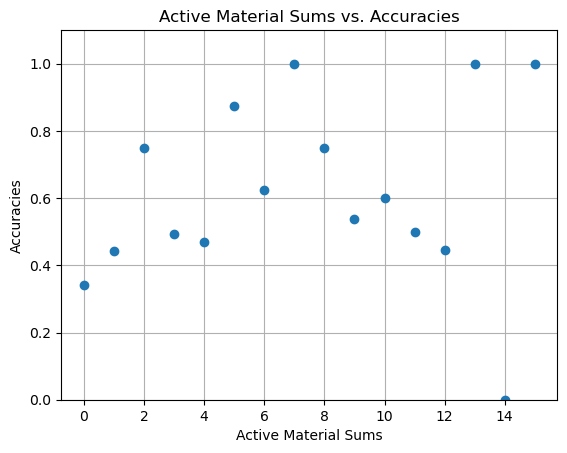

[1 0 3 9 5]


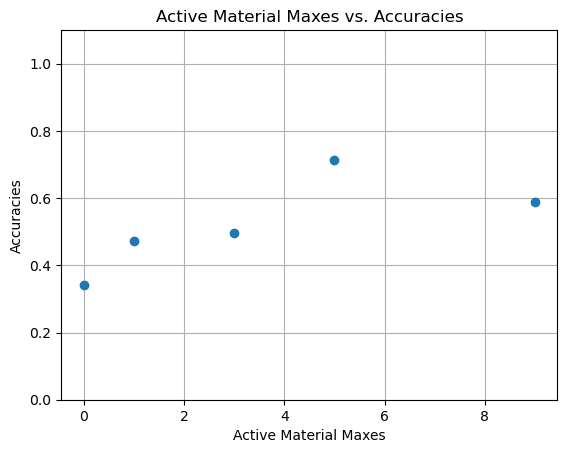

[  1   0  -4  -1  -3   2   4  -9  -8  -2   7  -6   6  11   3   5  -7   9
  -5 -11  10]


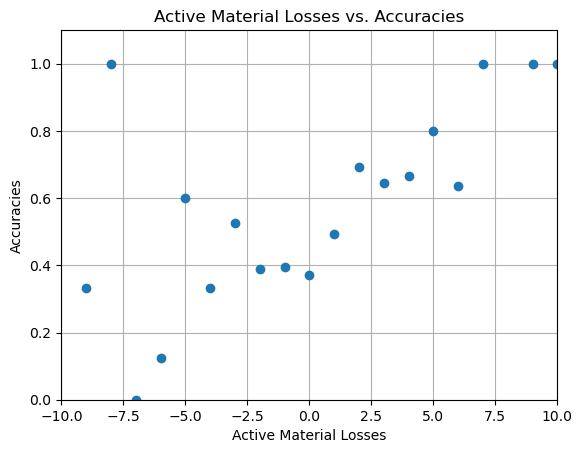

In [218]:
import matplotlib.pyplot as plt

plt.plot(active_material_sums, accuracies_sums, marker='o', linestyle='')
print(active_material_sums)
plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Sums')
plt.ylabel('Accuracies')
plt.title('Active Material Sums vs. Accuracies')
plt.grid(True)
plt.show()

plt.plot(active_material_maxes, accuracies_maxes, marker='o', linestyle='')
print(active_material_maxes)
plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Maxes')
plt.ylabel('Accuracies')
plt.title('Active Material Maxes vs. Accuracies')
plt.grid(True)
plt.show()

# active_material_sums & active_material_maxes may not show clear trend, as ppl don't prune equal exchanges
# need to look at unequal exchanges (or losses) for the player
print(active_material_losses)
plt.plot(active_material_losses, accuracies_losses, marker='o', linestyle='')
plt.xlim(-10, 10)
plt.ylim(0.0, 1.1)
plt.xlabel('Active Material Losses')
plt.ylabel('Accuracies')
plt.title('Active Material Losses vs. Accuracies')
plt.grid(True)
plt.show()

In [ ]:
# POST DRAFT/NEXT STEPS (???):
# get (joint) distribution for two heuristics:
# 1.) sum of materials across 5 stockfish moves associated with actual move
# 2.) change in stockfish evaluation score associated with actual move

def stockfish_score_dist(stockfish_score_accuracy_hm):
    stockfish_score_dist = []
    for score, count_list in stockfish_score_accuracy_hm.items():
        total_correct, total = count_list[0], count_list[1]
        accuracy = total_correct / total
        
        stockfish_score_dist.append([score, accuracy])
    return stockfish_score_dist

# NOTE: draft for joint distribution code --> is multiplication for joint valid? are two events independent? idts
def joint_dist(joint_accuracy_hm):
    joint_dist = []
    for joint_val, count_list in joint_accuracy_hm.items():
        total_correct, total = count_list[0], count_list[1]
        accuracy = total_correct / total
        
        joint_dist.append([joint_val, accuracy])
    return joint_dist

def get_distributions(desired_depth=15, num_moves=6):
#     if num_moves > desired_depth:
#         return []
        
    accuracy_maps_res = get_accuracy_maps(desired_depth, num_moves)
    material_delta_accuracy, stockfish_score_accuracy, joint_accuracy = accuracy_maps_res[0], accuracy_maps_res[1], accuracy_maps_res[2]
    material_distribution = material_dist(material_delta_accuracy)
    stockfish_score_distribution = stockfish_score_dist(stockfish_score_accuracy)
    joint_distribution = joint_dist(joint_accuracy)
    
    return [material_distribution, stockfish_score_distribution, joint_dist]